# Reflect Tables into SQLAlchemy ORM

In [10]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import datetime as dt

import numpy as np
import pandas as pd
from scipy import stats

In [11]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [15]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [16]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [17]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [18]:
# Save references to each table
Measurement=Base.classes.measurement
Station = Base.classes.station

In [19]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [23]:
# Find the most recent date in the data set.
inspector = inspect(engine)

meas_columns=inspector.get_columns('measurement')
print("Measurement")
for c in meas_columns:
    print(c['name'], c["type"])
    
station_columns= inspector.get_columns('station')
print("\nStations")
for c in station_columns:
    print(c['name'], c["type"])

Measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

Stations
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [25]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database. 
last_date = session.query(Measurement.date).\
            order_by(Measurement.date.desc()).first()
print(f"Last date is: {last_date[0]}")

# Calculate the date one year from the last date in data set.

last_year_date = (dt.datetime.strptime(last_date[0], '%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')
print(f"Date from one year ago is: {last_year_date}")


Last date is: 2017-08-23
Date from one year ago is: 2016-08-23


In [26]:
# Perform a query to retrieve the data and precipitation scores
measurement_cols = (Measurement.date, Measurement.prcp)

prcp_data = session.query(*measurement_cols).\
            filter(Measurement.date >= last_year_date).all()
prcp_data[:5]



[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0)]

In [28]:
# Save the query results as a Pandas DataFrame and set the index to the date column

prcp_df = pd.DataFrame(prcp_data,columns=['date','precipitation'])
prcp_df.head()


# Use Pandas Plotting with Matplotlib to plot the data

,date,precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [29]:
# Sort the dataframe by date

prcp_df.set_index('date',inplace=True)
prcp_df = prcp_df.sort_index()


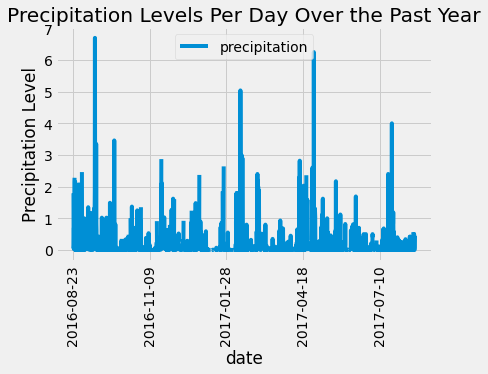

In [30]:
# Use Pandas to calcualte the summary statistics for the precipitation data
ax = prcp_df.plot(rot=90);
ax.set_title("Precipitation Levels Per Day Over the Past Year");
ax.set_ylabel("Precipitation Level");

In [31]:
prcp_df.describe()


,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [32]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(func.count(Station.id)).all()
station_count

[(9,)]

In [33]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
count_by_station =  session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()
count_by_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [34]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [35]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
USC00519281_data =  session.query(Measurement.date,Measurement.tobs).\
                    filter(Measurement.station == 'USC00519281').\
                    filter(Measurement.date > last_year_date).all()
USC00519281_data[:5]

[('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0)]

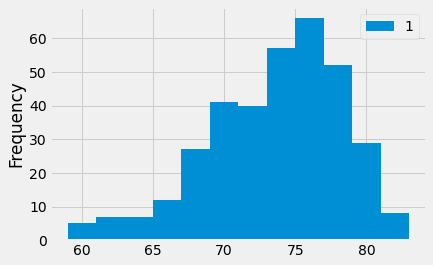

In [37]:
USC00519281_df= pd.DataFrame(USC00519281_data)
USC00519281_df.plot(kind="hist",bins=12);

# Close session

In [38]:
# Close Session
session.close()